## Import required libraries

In [49]:
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [50]:
raw_data = loadarff("./dataset/MW1.arff")
data = pd.DataFrame(raw_data[0])
data['Defective'] = data['Defective'].apply(lambda x: 1 if x.decode() == 'Y' else 0)
data.head()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,5.0,7.0,13.0,0.0,7.0,8.0,4.0,0.16,4.0,2.0,...,24.0,0.11,37.0,47.0,28.0,9.0,38.0,21.88,25.0,0
1,5.0,21.0,3.0,1.0,2.0,24.0,11.0,0.30,4.0,6.0,...,23.0,0.24,75.0,86.0,32.0,16.0,45.0,7.69,37.0,0
2,2.0,5.0,0.0,0.0,4.0,8.0,3.0,0.33,4.0,2.0,...,9.0,0.19,10.0,17.0,6.0,9.0,16.0,30.77,9.0,0
3,3.0,5.0,3.0,0.0,15.0,8.0,3.0,0.19,4.0,2.0,...,12.0,0.09,22.0,33.0,12.0,14.0,35.0,48.39,16.0,1
4,3.0,5.0,2.0,0.0,5.0,8.0,3.0,0.43,4.0,2.0,...,12.0,0.19,19.0,22.0,8.0,10.0,16.0,41.67,7.0,0


In [51]:
def MCC(yt,yp):
    tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
    #print(confusion_matrix(yt, yp))
    den=(tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    if den==0:
        den=1
    return (tp*tn-fp*fn)/den**0.5

## Model Training and Testing without Feature Selection

In [52]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [53]:
knn = KNeighborsClassifier(n_neighbors = 89)
knn.fit(X_train, y_train)
print(f"Score: {knn.score(X_test, y_test)}")
y_pred=knn.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9342105263157895
MCC: 0.0


### Naive Bayes

In [54]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"Score: {gnb.score(X_test, y_test)}")
y_pred=gnb.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7763157894736842
MCC: 0.22668076025854925


### Decision Tree

In [55]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print(f"Score: {dtc.score(X_test, y_test)}")
y_pred=dtc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7894736842105263
MCC: 0.020400300173236734


### Random Forest

In [56]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(f"Score: {rfc.score(X_test, y_test)}")
y_pred=rfc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8947368421052632
MCC: 0.14366197183098592


### AdaBoost

In [57]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
print(f"Score: {abc.score(X_test, y_test)}")
y_pred=abc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.881578947368421
MCC: 0.11912941522604424


## Correlation Matrix of Dataset

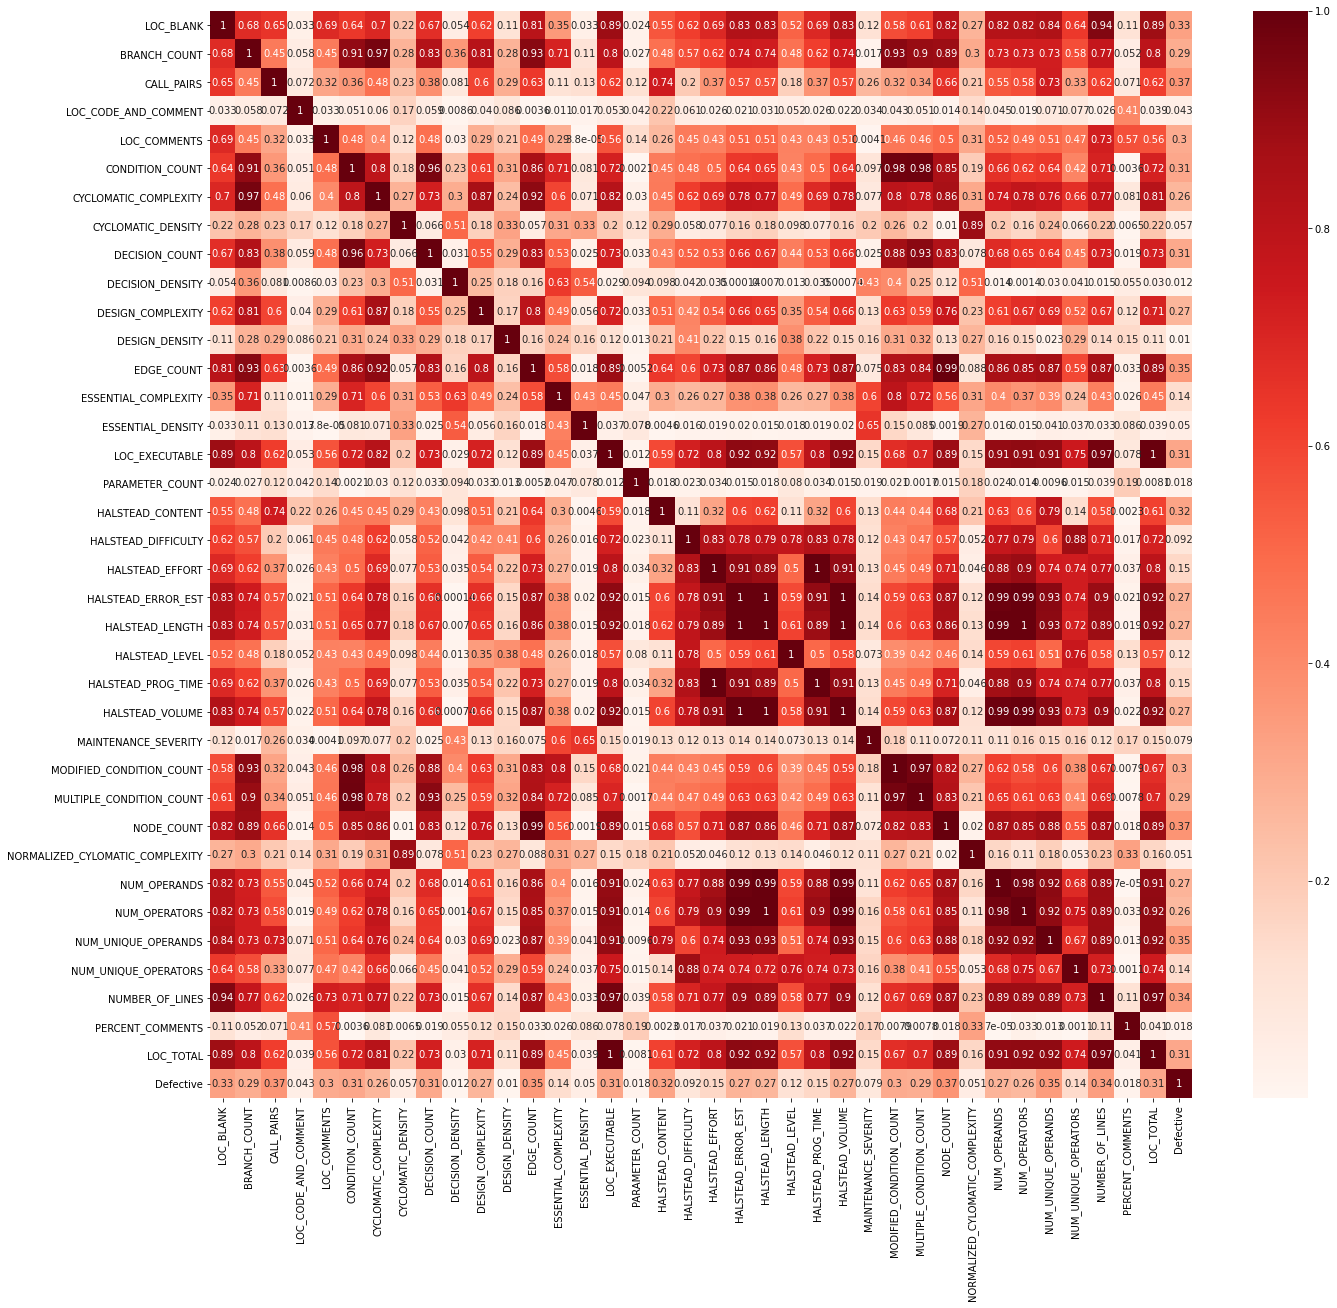

In [58]:
correlation_matrix = data.corr().abs()
plt.figure(figsize = (22, 20))
sns.heatmap(correlation_matrix, annot = True, cmap = plt.cm.Reds)
plt.show()

## Model training and testing with Hybrid Feature Selection

In [59]:
upper_triangular_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
features_to_drop = [column for column in upper_triangular_matrix.columns if any(upper_triangular_matrix[column] > 0.95)]
print("Features to drop: ", features_to_drop)
data = data.drop(features_to_drop, axis = 1)
data.head()

Features to drop:  ['CYCLOMATIC_COMPLEXITY', 'DECISION_COUNT', 'HALSTEAD_LENGTH', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUMBER_OF_LINES', 'LOC_TOTAL']


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_DENSITY,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,...,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LEVEL,MAINTENANCE_SEVERITY,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,PERCENT_COMMENTS,Defective
0,5.0,7.0,13.0,0.0,7.0,8.0,0.16,2.0,4.0,1.00,...,5.95,2602.12,0.15,0.17,0.25,0.11,28.0,9.0,21.88,0
1,5.0,21.0,3.0,1.0,2.0,24.0,0.30,6.0,2.0,0.18,...,18.75,16859.61,0.30,0.05,0.91,0.24,32.0,16.0,7.69,0
2,2.0,5.0,0.0,0.0,4.0,8.0,0.33,2.0,1.0,0.33,...,7.50,791.15,0.04,0.13,0.33,0.19,6.0,9.0,30.77,0
3,3.0,5.0,3.0,0.0,15.0,8.0,0.19,2.0,2.0,0.67,...,12.83,3317.73,0.09,0.08,0.33,0.09,12.0,14.0,48.39,1
4,3.0,5.0,2.0,0.0,5.0,8.0,0.43,2.0,2.0,0.67,...,11.88,2030.23,0.06,0.08,0.33,0.19,8.0,10.0,41.67,0


In [60]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [62]:
knn = KNeighborsClassifier(n_neighbors=89)
sfs = SequentialFeatureSelector(knn)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
knn.fit(X_train_sfs, y_train)
print(f"Score: {knn.score(X_test_sfs, y_test)}")
y_pred=knn.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.9342105263157895
MCC: 0.0


Selected features for KNN

In [63]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
       'LOC_COMMENTS', 'CONDITION_COUNT', 'CYCLOMATIC_DENSITY',
       'DECISION_DENSITY', 'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'EDGE_COUNT',
       'ESSENTIAL_COMPLEXITY'],
      dtype='object')

### Naive Bayes

In [67]:
gnb = GaussianNB()
sfs = SequentialFeatureSelector(gnb)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
gnb.fit(X_train_sfs, y_train)
print(f"Score: {gnb.score(X_test_sfs, y_test)}")
y_pred=gnb.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8289473684210527
MCC: 0.28463155657101824


Selected Features for Naive Bayes

In [68]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['CYCLOMATIC_DENSITY', 'DECISION_DENSITY', 'DESIGN_COMPLEXITY',
       'DESIGN_DENSITY', 'EDGE_COUNT', 'ESSENTIAL_COMPLEXITY',
       'PARAMETER_COUNT', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
       'MAINTENANCE_SEVERITY', 'NORMALIZED_CYLOMATIC_COMPLEXITY',
       'PERCENT_COMMENTS'],
      dtype='object')

### Decision Tree

In [69]:
dtc = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(dtc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
dtc.fit(X_train_sfs, y_train)
print(f"Score: {dtc.score(X_test_sfs, y_test)}")
y_pred=dtc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8157894736842105
MCC: 0.16134782864287234


Selected features for Decision Tree

In [70]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'DECISION_DENSITY',
       'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY',
       'ESSENTIAL_DENSITY', 'PARAMETER_COUNT', 'HALSTEAD_CONTENT',
       'MAINTENANCE_SEVERITY', 'NORMALIZED_CYLOMATIC_COMPLEXITY'],
      dtype='object')

### Random Forest

In [71]:
rfc = RandomForestClassifier()
sfs = SequentialFeatureSelector(rfc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
rfc.fit(X_train_sfs, y_train)
print(f"Score: {rfc.score(X_test_sfs, y_test)}")
y_pred=rfc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8947368421052632
MCC: -0.05379662433186815


Selected features for Random Forest

In [72]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'LOC_CODE_AND_COMMENT', 'CYCLOMATIC_DENSITY',
       'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY',
       'ESSENTIAL_DENSITY', 'PARAMETER_COUNT', 'HALSTEAD_EFFORT',
       'HALSTEAD_ERROR_EST', 'HALSTEAD_LEVEL', 'MAINTENANCE_SEVERITY'],
      dtype='object')

### AdaBoost

In [73]:
abc = AdaBoostClassifier()
sfs = SequentialFeatureSelector(abc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
abc.fit(X_train_sfs, y_train)
print(f"Score: {abc.score(X_test_sfs, y_test)}")
y_pred=abc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8947368421052632
MCC: 0.14366197183098592


Selected features for AdaBoost Classifier

In [74]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'DECISION_DENSITY', 'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY',
       'ESSENTIAL_DENSITY', 'PARAMETER_COUNT', 'MAINTENANCE_SEVERITY',
       'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_UNIQUE_OPERATORS',
       'PERCENT_COMMENTS'],
      dtype='object')